

```
# author: puru panta (purupanta@uky.edu)
# date: 11/30/2024
# filename: PredictMLDL_Stacked
```



**STEP1: Install and Import libraries required**

In [ ]:
import json
import time

In [ ]:
!pip install --upgrade tf-keras
!pip install --upgrade tensorflow
!pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
# Mounting google drive if it is already not mounted
def LoadGoogleDrive(googleDriveDir):
  # Link Google Drive
  import os
  # Check if Google Drive is already mounted
  if not os.path.exists(googleDriveDir + "/MyDrive"):
      print("Mounting Google Drive...")
      from google.colab import drive
      drive.mount(googleDriveDir)
  else:
      print("Google Drive is already mounted!")

# Loading the AppConfig file
def LoadAppConfig(json_file_path):
  # Load JSON file into a Python dictionary
  with open(json_file_path, "r") as json_file:
      config_data = json.load(json_file)

  # Print loaded JSON data
  print("AppConfig JSON File Loaded Successfully!")
  # print(config_data)
  return config_data

# Loading the AppLib file
def AppLib_reload_script(script_path):
  # Load AppLib.py
  with open(script_path, 'r') as file:
      script_code = file.read()
      exec(script_code, globals())

**STEP2: Load google-drive, libraries, config file and application library file**

In [ ]:
# Mount the google drive
googleDriveFolder = "/content/drive"
LoadGoogleDrive(googleDriveFolder)

# Load the AppConfig json file
json_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/HINTS6Finale/AppConfig.json"
config_data = LoadAppConfig(json_file_path)

# Load AppLib
lib_script_path = config_data["project_location"] + config_data["app_lib_path"] + config_data["app_lib_filename"]
print(f"Loading AppLib from: {lib_script_path}")
AppLib_reload_script(lib_script_path)


Mounting Google Drive...
Mounted at /content/drive
AppConfig JSON File Loaded Successfully!
Loading AppLib from: drive/MyDrive/Colab Notebooks/HINTS6Finale/lib/AppLib.py


In [ ]:
requirements_path = config_data["project_location"] + config_data["requirements_file_name"]
AppLib.LoadRequirements(requirements_path)

Installing missing packages: ['tf-keras', 'scikit-learn', 'imbalanced-learn', 'xlsxwriter']
Installation completed successfully!
Please restart the runtime for changes to take effect.


**STEP3: Load the original data with filtered columns**

In [ ]:
# Define the output file path
ip_file_path = config_data["project_location"] + config_data["op_data_dir"] + config_data["op_file_name_cleaned"];
ip_sheet_name = config_data["op_file_sheet_name_cleaned"]
ip_load_data_cols = config_data["study_cols"]["target_cols"] + config_data["study_cols"]["predictor_cols"] + config_data["study_cols"]["predictor_cols0"]

# Loading cleaded excel data
df_rowColFilteredCleaned = AppLib.load_data(ip_file_path, ip_sheet_name, ip_load_data_cols)


Data Size: 87750, Data Shape: (4875, 18), (Flag: Loaded, original data)


In [ ]:
df = df_rowColFilteredCleaned.copy()

**STEP4: Define target and predictors**

In [ ]:
predictors = config_data["study_cols"]["predictor_cols"] + config_data["study_cols"]["predictor_cols0"]
target = config_data["study_cols"]["target_cols"]
X, y = AppLib.define_target_predictors(df, predictors, target)

Unique values in the target variable after filtering: [1 0]


**STEP5: Data Standard-Scale**

In [ ]:
## Standardize scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**STEP6: SMOTE Data**

In [ ]:
# 'smote_data'
# SMOTE is used to handle class imbalance during the training process to help the model learn better representations for the minority class. It artificially generates new samples for the minority class by interpolating between existing samples.
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

**STEP7: Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# Reshape the target variable if necessary
y_train = y_train.to_numpy().ravel()  # Convert to 1D array
y_test = y_test.to_numpy().ravel()    # Convert to 1D array (if needed)


**STEP8: Prediction Starts**

**1. Stacked Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

In [ ]:
# Train/Test assignments
X_train_stacked = X_train.copy()
y_train_stacked = y_train.copy()
X_test_stacked = X_test.copy()
y_test_stacked = y_test.copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
!pip install --upgrade tensorflow
# %%
!pip install --upgrade scikeras # Upgrade scikeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

def build_ann():
  model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

wrapped_ann = KerasClassifier(model=build_ann, epochs=50, batch_size=32, verbose=0)


Stacked Model Accuracy: 0.97
Stacked Model Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.97      0.97       886
     Class 1       0.97      0.96      0.97       882

    accuracy                           0.97      1768
   macro avg       0.97      0.97      0.97      1768
weighted avg       0.97      0.97      0.97      1768

Stacked Model AUC-ROC: 1.00


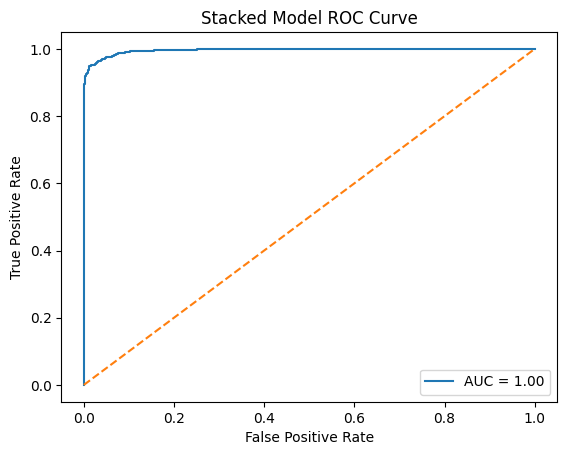

Total execution time: 78.24 seconds


In [ ]:
# Define base learners

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
    ('lr', LogisticRegression(solver='liblinear', random_state=42)),
    ('svm', SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),

]

# Start timing
start_time = time.time()

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
    ('lr', LogisticRegression(solver='liblinear', random_state=42)),
    ('svm', SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    # ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    # ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
    # ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
    # ('ann', wrapped_ann),
    # ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  # XGBoost added
]


# Meta-model
meta_model = LogisticRegression(solver='liblinear', random_state=42)

# Stacking Classifier
# stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)

stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=False  # Exclude raw features in the meta-learner
)


# Train the stacked model
stacked_model.fit(X_train_stacked, y_train_stacked.ravel())

# Predictions and evaluation
y_pred_stacked = stacked_model.predict(X_test)
y_prob_stacked = stacked_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
print(f"Stacked Model Accuracy: {accuracy_stacked:.2f}")

# Classification report
target_names = ['Class 0', 'Class 1']
report_stacked = classification_report(y_test, y_pred_stacked, target_names=target_names)
print("Stacked Model Classification Report:\n", report_stacked)

# AUC-ROC
auc_roc_stacked = roc_auc_score(y_test, y_prob_stacked)
print(f"Stacked Model AUC-ROC: {auc_roc_stacked:.2f}")

# ROC Curve
fpr_stacked, tpr_stacked, thresholds_stacked = roc_curve(y_test, y_prob_stacked)
plt.plot(fpr_stacked, tpr_stacked, label=f'AUC = {auc_roc_stacked:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacked Model ROC Curve')
plt.legend()
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")
